In [1]:
import torch
from torch_geometric.utils import remove_self_loops, coalesce
from Models.GAE import Encoder, Decoder, GAE
# from GAE_1 import Encoder, Decoder, GAE
from torchinfo import summary
from torch_geometric.data import Data
import numpy as np
import torch.optim as optim
import scipy
import os
import Models.Get_data as Gd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from copy import deepcopy

from tqdm import tqdm  
import matplotlib.pyplot as plt
from kmeans_pytorch import kmeans, kmeans_predict

import random

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)

In [3]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [4]:
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# Get data

In [5]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
pos = torch.tensor(np.load(xyfile), dtype=torch.float32)

In [6]:
sparse_graph = scipy.sparse.load_npz('/home/wl4023/data/Sibo_22Mar2024/sparse_matrix_fixed_weighted.npz')
indices = np.array(sparse_graph.nonzero())
values = sparse_graph.data
shape = sparse_graph.shape

# sparse edge tensor
edge_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float).coalesce()
edge_index = edge_tensor.indices()
# edge_weight = edge_tensor.values()
# edge_weight = edge_weight.unsqueeze(1)
print(edge_tensor.shape)
print(edge_index)
# print(edge_weight)

torch.Size([97149, 97149])
tensor([[    0,     0,     1,  ..., 97148, 97148, 97148],
        [    1,     3,     0,  ..., 97145, 97146, 97147]])


In [7]:
distance = torch.norm(pos[edge_index[0]]-pos[edge_index[1]], dim=1)
print(distance)

tensor([0.0029, 0.0039, 0.0029,  ..., 0.0024, 0.0021, 0.0024])


In [8]:
edge_weight = 1/(distance)
edge_weight = edge_weight/torch.sum(edge_weight)*1000
edge_weight = edge_weight.unsqueeze(1)
print(f'{edge_weight.max():.8f}, {edge_weight.min():.8f}')

0.02281803, 0.00025737


In [9]:
latent_space = 20
num_mp_layers = [2, 2, 2]
num_clusters = [1000, latent_space]
clusters = []
centroids = []

In [10]:
centroid = deepcopy(pos)

for i in num_clusters:
    cluster, centroid = kmeans(centroid, i, device=pos.device)
    print(centroid.shape)
    clusters.append(cluster)
    centroids.append(centroid)
    
torch.save(centroids, 'centroids.pt')
torch.save(clusters, 'clusters.pt')

running k-means on cpu..


[running kmeans]: 81it [00:23,  3.43it/s, center_shift=0.000077, iteration=81, tol=0.000100]


torch.Size([1000, 2])
running k-means on cpu..


[running kmeans]: 31it [00:00, 1256.08it/s, center_shift=0.000000, iteration=31, tol=0.000100]

torch.Size([20, 2])


## Train and val data

In [11]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [12]:
train_tensor = torch.tensor(train_np, dtype=torch.float)
train_tensor_set = Gd.MyDataset(train_tensor)
val_tensor = torch.tensor(val_np, dtype=torch.float)
val_tensor_set = Gd.MyDataset(val_tensor)

In [13]:
preprocessor = Gd.Preprocessor()
preprocessor.fit(torch.concat((train_tensor, val_tensor), axis=0))

In [14]:
print(preprocessor.mean)
print(preprocessor.std)

tensor(6.9571)
tensor(9.8111)


## Test data

In [15]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)
test_tensor = torch.tensor(test_np, dtype=torch.float)
test_tensor_set = Gd.MyDataset(test_tensor)

In [16]:
print(folders[-1:])

['/home/wl4023/data/Sibo_22Mar2024/case_23/hessian_']


# Train

In [17]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))

class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [18]:
def check_for_nan_or_inf(tensor, name):
    if torch.isnan(tensor).any():
        print(f"Tensor {name} contains NaN values.")
    if torch.isinf(tensor).any():
        print(f"Tensor {name} contains Inf values.")

In [19]:
def train(model, train_set, val_set, edge_index, edge_attr, pos, criterion, optimizer, device, metric_train, metric_val, epochs=30):
    edge_index, edge_attr, pos = edge_index.to(device), edge_attr.to(device), pos.to(device)

    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []
    min_loss = 100000
    # ss = 0
    for i in range(epochs):
        model.train()
        train_loss = 0
        relative_train_loss = 0
        for x in tqdm(train_set):
            
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         if torch.isnan(param.grad).any():
            #             print(f"Gradient of parameter {name} contains NaN, {ss}")
            # ss = ss+1
            input = preprocessor.transform(x)
            input = input.to(device)
            x = x.to(device)
            optimizer.zero_grad()
            predict, _, _ = model(input, edge_index, edge_attr, pos)
            # print(predict.max(), predict.min(), x.max(), x.min())
            # 在计算损失之前检查输入
            check_for_nan_or_inf(predict, "y_pred")
            check_for_nan_or_inf(input, "y_true")
            loss = criterion(input, predict)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            train_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
            relative_train_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

        train_loss = train_loss/len(train_set)
        relative_train_loss /= len(train_set)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(relative_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            relative_val_loss = 0
            for x in val_set:
                input = preprocessor.transform(x)
                input = input.to(device)
                x = x.to(device)
                predict, _, _ = model(input, edge_index, edge_attr, pos)

                loss = criterion(input, predict)
                val_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
                relative_val_loss += metric_val(x, preprocessor.inverse_transform(predict)).item()


            val_loss /= len(val_set)
            relative_val_loss /= len(val_set)

            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(relative_val_loss)

        print(f'Epoch {i + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {relative_train_loss}, val Loss: {val_loss}, NRMSE_val_loss: {relative_val_loss}')
        if min_loss >= relative_val_loss:
            min_loss = relative_val_loss
            torch.save(model.state_dict(), 'GAE_kmeans.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [20]:
# Define the weights initialization function
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

In [21]:
model = GAE(1, 1, num_mp_layers, clusters, centroids, 16, 3)
model.apply(initialize_weights)
summary(model, input_data=(train_tensor[0], edge_index, edge_weight, pos))


Layer (type:depth-idx)                             Output Shape              Param #
GAE                                                [97149, 1]                --
├─Encoder: 1-1                                     [20, 16]                  --
│    └─ModuleList: 2-5                             --                        (recursive)
│    │    └─Linear: 3-1                            [97149, 16]               32
│    └─ELU: 2-2                                    [97149, 16]               --
│    └─ModuleList: 2-5                             --                        (recursive)
│    │    └─Linear: 3-2                            [97149, 16]               272
│    └─ELU: 2-4                                    [97149, 16]               --
│    └─ModuleList: 2-5                             --                        (recursive)
│    │    └─Linear: 3-3                            [97149, 16]               272
│    └─ELU: 2-6                                    [97149, 16]               --
│    └

In [22]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters())
metric_train = NRMSE(train_tensor)
metric_val = NRMSE(val_tensor)
model.to(device)
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_tensor_set,
                                                                                         val_tensor_set,
                                                                                         edge_index,
                                                                                         edge_weight,
                                                                                         pos,
                                                                                         criterion,
                                                                                         optimizer,
                                                                                         device,
                                                                                         metric_train,
                                                                                         metric_val, 
                                                                                         epochs=50)

100%|██████████| 2320/2320 [01:40<00:00, 23.12it/s]


Epoch 1/50, train Loss: 3.3359336505804595, NRMSE_train_loss: 0.06415165915587467, val Loss: 2.7178078761388518, NRMSE_val_loss: 0.05223889510741393


100%|██████████| 2320/2320 [01:41<00:00, 22.91it/s]


Epoch 2/50, train Loss: 2.3580885553668285, NRMSE_train_loss: 0.04534721286537864, val Loss: 3.125424220233128, NRMSE_val_loss: 0.06007367538464866


100%|██████████| 2320/2320 [01:41<00:00, 22.95it/s]


Epoch 3/50, train Loss: 2.1005440368670327, NRMSE_train_loss: 0.04039450397670815, val Loss: 2.264562691773834, NRMSE_val_loss: 0.043527084468574874


100%|██████████| 2320/2320 [01:41<00:00, 22.96it/s]


Epoch 4/50, train Loss: 1.992824558380606, NRMSE_train_loss: 0.03832300493919194, val Loss: 1.8675346361152056, NRMSE_val_loss: 0.0358958213196682


100%|██████████| 2320/2320 [01:41<00:00, 22.96it/s]


Epoch 5/50, train Loss: 1.8798878835064583, NRMSE_train_loss: 0.036151176710625114, val Loss: 2.029495014198895, NRMSE_val_loss: 0.03900885633835248


100%|██████████| 2320/2320 [01:41<00:00, 22.96it/s]


Epoch 6/50, train Loss: 1.7507713815646953, NRMSE_train_loss: 0.03366820228392467, val Loss: 1.8915133715189736, NRMSE_val_loss: 0.03635671586279982


100%|██████████| 2320/2320 [01:41<00:00, 22.90it/s]


Epoch 7/50, train Loss: 1.4519729851841412, NRMSE_train_loss: 0.027922160917058073, val Loss: 1.662567786872387, NRMSE_val_loss: 0.031956160335062905


100%|██████████| 2320/2320 [01:41<00:00, 22.93it/s]


Epoch 8/50, train Loss: 1.3635621642693878, NRMSE_train_loss: 0.026221976948376136, val Loss: 1.4737381159745413, NRMSE_val_loss: 0.028326671424819608


100%|██████████| 2320/2320 [01:41<00:00, 22.95it/s]


Epoch 9/50, train Loss: 1.3170177089756934, NRMSE_train_loss: 0.025326903955709863, val Loss: 1.6768866429811922, NRMSE_val_loss: 0.03223138256801356


100%|██████████| 2320/2320 [01:41<00:00, 22.95it/s]


Epoch 10/50, train Loss: 1.27809249057017, NRMSE_train_loss: 0.024578352688695303, val Loss: 1.4020219568034697, NRMSE_val_loss: 0.026948217505685473


100%|██████████| 2320/2320 [01:40<00:00, 23.14it/s]


Epoch 11/50, train Loss: 1.2178928973570724, NRMSE_train_loss: 0.023420684676765915, val Loss: 1.679550943703487, NRMSE_val_loss: 0.0322825930282024


100%|██████████| 2320/2320 [01:40<00:00, 23.16it/s]


Epoch 12/50, train Loss: 1.1955934097155414, NRMSE_train_loss: 0.02299185441004048, val Loss: 1.3679301350281157, NRMSE_val_loss: 0.02629293971534433


100%|██████████| 2320/2320 [01:40<00:00, 23.18it/s]


Epoch 13/50, train Loss: 1.1744148153008829, NRMSE_train_loss: 0.02258457958824724, val Loss: 1.4624143043211821, NRMSE_val_loss: 0.028109016854733486


100%|██████████| 2320/2320 [01:40<00:00, 23.19it/s]


Epoch 14/50, train Loss: 1.1653852349532576, NRMSE_train_loss: 0.02241093626959402, val Loss: 1.335275783826565, NRMSE_val_loss: 0.02566529159225395


100%|██████████| 2320/2320 [01:40<00:00, 23.09it/s]


Epoch 15/50, train Loss: 1.124029438705023, NRMSE_train_loss: 0.02161564380151284, val Loss: 1.280419594100837, NRMSE_val_loss: 0.024610902598641557


100%|██████████| 2320/2320 [01:40<00:00, 23.19it/s]


Epoch 16/50, train Loss: 1.11612671569054, NRMSE_train_loss: 0.021463670477808998, val Loss: 1.119538013251691, NRMSE_val_loss: 0.02151860306681744


100%|██████████| 2320/2320 [01:40<00:00, 23.12it/s]


Epoch 17/50, train Loss: 1.0914764492611946, NRMSE_train_loss: 0.02098963363798624, val Loss: 1.389553400719988, NRMSE_val_loss: 0.026708559859704613


100%|██████████| 2320/2320 [01:40<00:00, 23.15it/s]


Epoch 18/50, train Loss: 1.081480509585476, NRMSE_train_loss: 0.020797406745861797, val Loss: 1.178374954081815, NRMSE_val_loss: 0.02264950591910245


100%|██████████| 2320/2320 [01:40<00:00, 23.15it/s]


Epoch 19/50, train Loss: 1.0455054095978367, NRMSE_train_loss: 0.020105587748373087, val Loss: 1.1156670599405107, NRMSE_val_loss: 0.021444199541342798


100%|██████████| 2320/2320 [01:40<00:00, 23.15it/s]


Epoch 20/50, train Loss: 1.0514319320691043, NRMSE_train_loss: 0.020219557696716572, val Loss: 1.4635221665789342, NRMSE_val_loss: 0.028130311024744576


100%|██████████| 2320/2320 [01:40<00:00, 23.16it/s]


Epoch 21/50, train Loss: 1.0474274426987715, NRMSE_train_loss: 0.02014254938754863, val Loss: 1.2690497731340342, NRMSE_val_loss: 0.02439236363139132


100%|██████████| 2320/2320 [01:40<00:00, 23.09it/s]


Epoch 22/50, train Loss: 1.0196308519723343, NRMSE_train_loss: 0.019608007162580557, val Loss: 1.1030809521032818, NRMSE_val_loss: 0.021202282414466526


100%|██████████| 2320/2320 [01:40<00:00, 23.11it/s]


Epoch 23/50, train Loss: 1.0008533784509477, NRMSE_train_loss: 0.019246907040912354, val Loss: 1.0561358621665116, NRMSE_val_loss: 0.02029995239612743


100%|██████████| 2320/2320 [01:40<00:00, 23.18it/s]


Epoch 24/50, train Loss: 0.9844212127753116, NRMSE_train_loss: 0.018930908318775592, val Loss: 1.033699162779697, NRMSE_val_loss: 0.019868697310749698


100%|██████████| 2320/2320 [01:40<00:00, 23.07it/s]


Epoch 25/50, train Loss: 0.9776331969376268, NRMSE_train_loss: 0.01880037143017599, val Loss: 1.1553628077280933, NRMSE_val_loss: 0.02220719026016264


100%|██████████| 2320/2320 [01:40<00:00, 23.12it/s]


Epoch 26/50, train Loss: 0.9697054675555434, NRMSE_train_loss: 0.018647917255895725, val Loss: 1.2576736621558666, NRMSE_val_loss: 0.024173703833467102


100%|██████████| 2320/2320 [01:40<00:00, 23.13it/s]


Epoch 27/50, train Loss: 0.9578128235928457, NRMSE_train_loss: 0.01841921580630226, val Loss: 1.0591026205441048, NRMSE_val_loss: 0.020356976350464313


100%|██████████| 2320/2320 [01:40<00:00, 23.09it/s]


Epoch 28/50, train Loss: 0.9665502801023681, NRMSE_train_loss: 0.01858724144534288, val Loss: 1.1822365749627353, NRMSE_val_loss: 0.022723729981928422


100%|██████████| 2320/2320 [01:40<00:00, 23.14it/s]


Epoch 29/50, train Loss: 0.9377822754840399, NRMSE_train_loss: 0.018034018414468375, val Loss: 0.9235362909477333, NRMSE_val_loss: 0.017751260397249256


100%|██████████| 2320/2320 [01:40<00:00, 23.18it/s]


Epoch 30/50, train Loss: 0.9402239367815441, NRMSE_train_loss: 0.018080972773795705, val Loss: 1.15992170233151, NRMSE_val_loss: 0.022294816614032306


100%|██████████| 2320/2320 [01:40<00:00, 23.13it/s]


Epoch 31/50, train Loss: 0.930294004371711, NRMSE_train_loss: 0.017890015230634538, val Loss: 0.9174055265712326, NRMSE_val_loss: 0.01763342119721246


100%|██████████| 2320/2320 [01:40<00:00, 23.18it/s]


Epoch 32/50, train Loss: 0.9328068270733387, NRMSE_train_loss: 0.017938338082026817, val Loss: 1.0807623966500677, NRMSE_val_loss: 0.020773298178542534


100%|██████████| 2320/2320 [01:40<00:00, 23.12it/s]


Epoch 33/50, train Loss: 0.9125226459273234, NRMSE_train_loss: 0.017548263212314664, val Loss: 0.9917254220822762, NRMSE_val_loss: 0.01906192147269331


100%|██████████| 2320/2320 [01:40<00:00, 23.15it/s]


Epoch 34/50, train Loss: 0.9127173136791279, NRMSE_train_loss: 0.017552006767223717, val Loss: 0.8992739294495048, NRMSE_val_loss: 0.017284914371477247


100%|██████████| 2320/2320 [01:40<00:00, 23.14it/s]


Epoch 35/50, train Loss: 0.9122407682496926, NRMSE_train_loss: 0.017542842566236404, val Loss: 0.9119918397531427, NRMSE_val_loss: 0.017529364910924102


100%|██████████| 2320/2320 [01:40<00:00, 23.07it/s]


Epoch 36/50, train Loss: 0.9038319687487494, NRMSE_train_loss: 0.01738113718697448, val Loss: 1.1450360979627947, NRMSE_val_loss: 0.022008700915893284


100%|██████████| 2320/2320 [01:40<00:00, 23.13it/s]


Epoch 37/50, train Loss: 0.9159676563508552, NRMSE_train_loss: 0.017614512484327986, val Loss: 1.3390272686707563, NRMSE_val_loss: 0.02573739874802915


100%|██████████| 2320/2320 [01:40<00:00, 23.13it/s]


Epoch 38/50, train Loss: 0.8907642377990073, NRMSE_train_loss: 0.017129838232107557, val Loss: 0.8546344480252471, NRMSE_val_loss: 0.01642690038806277


100%|██████████| 2320/2320 [01:40<00:00, 23.11it/s]


Epoch 39/50, train Loss: 0.8879750494138691, NRMSE_train_loss: 0.017076200754271322, val Loss: 0.9146518454469483, NRMSE_val_loss: 0.017580492825022546


100%|██████████| 2320/2320 [01:40<00:00, 23.09it/s]


Epoch 40/50, train Loss: 0.8753510514049437, NRMSE_train_loss: 0.016833435006064348, val Loss: 0.9684362767328476, NRMSE_val_loss: 0.018614281611998792


100%|██████████| 2320/2320 [01:40<00:00, 23.15it/s]


Epoch 41/50, train Loss: 0.8703315866276108, NRMSE_train_loss: 0.01673690821771743, val Loss: 0.9751924321055412, NRMSE_val_loss: 0.018744141381667478


100%|██████████| 2320/2320 [01:40<00:00, 23.11it/s]


Epoch 42/50, train Loss: 0.8633883945708131, NRMSE_train_loss: 0.016603387173180918, val Loss: 0.9411361929671518, NRMSE_val_loss: 0.018089547526524884


100%|██████████| 2320/2320 [01:40<00:00, 23.15it/s]


Epoch 43/50, train Loss: 0.8630496048561201, NRMSE_train_loss: 0.016596872091959713, val Loss: 1.1106415254288706, NRMSE_val_loss: 0.021347603913203908


100%|██████████| 2320/2320 [01:40<00:00, 23.17it/s]


Epoch 44/50, train Loss: 0.8497159910837895, NRMSE_train_loss: 0.01634046008724093, val Loss: 0.9505298234008509, NRMSE_val_loss: 0.018270102225581248


100%|██████████| 2320/2320 [01:40<00:00, 23.13it/s]


Epoch 45/50, train Loss: 0.8613304185520472, NRMSE_train_loss: 0.01656381129357434, val Loss: 0.9911227225229657, NRMSE_val_loss: 0.019050336937050754


100%|██████████| 2320/2320 [01:40<00:00, 23.14it/s]


Epoch 46/50, train Loss: 0.8534103580268806, NRMSE_train_loss: 0.01641150460220223, val Loss: 1.208230981282119, NRMSE_val_loss: 0.02322336760718889


100%|██████████| 2320/2320 [01:40<00:00, 23.10it/s]


Epoch 47/50, train Loss: 0.849318931608236, NRMSE_train_loss: 0.01633282442795964, val Loss: 1.1329972958770291, NRMSE_val_loss: 0.021777303488764527


100%|██████████| 2320/2320 [01:40<00:00, 23.14it/s]


Epoch 48/50, train Loss: 0.8360102375070083, NRMSE_train_loss: 0.01607689165248303, val Loss: 0.9588270878997343, NRMSE_val_loss: 0.018429583654706847


100%|██████████| 2320/2320 [01:40<00:00, 23.15it/s]


Epoch 49/50, train Loss: 0.8572259449721154, NRMSE_train_loss: 0.01648488021465741, val Loss: 1.1432040286346756, NRMSE_val_loss: 0.021973486721981315


100%|██████████| 2320/2320 [01:40<00:00, 23.17it/s]


Epoch 50/50, train Loss: 0.841446023508264, NRMSE_train_loss: 0.0161814245016009, val Loss: 0.8795444174830256, NRMSE_val_loss: 0.016905694090809414


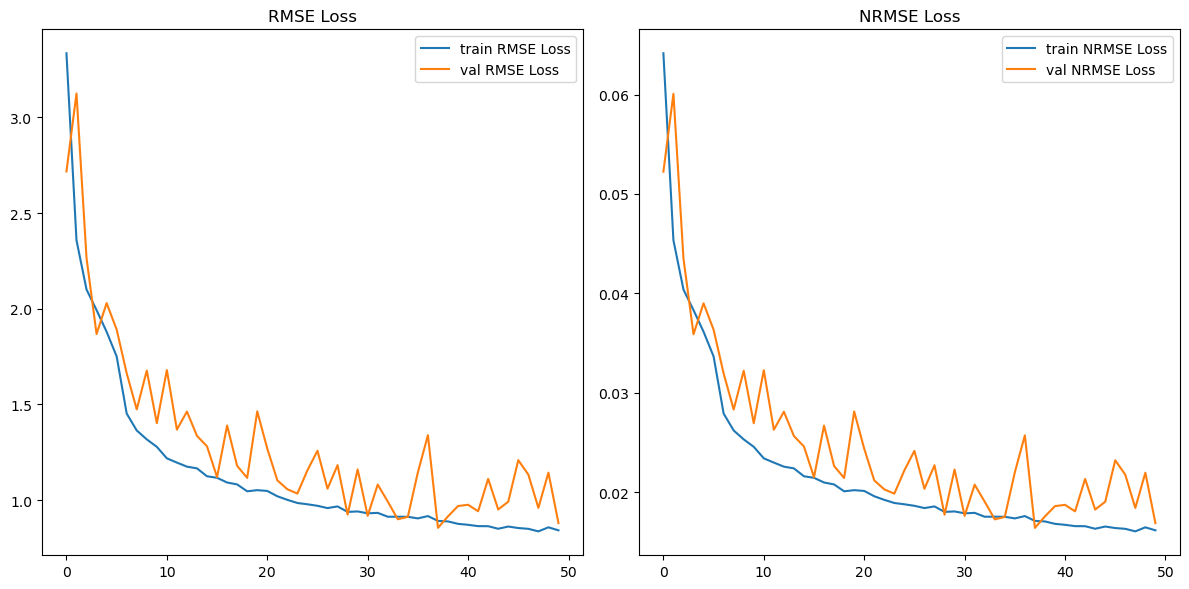

In [23]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
plt.savefig('GAE_train_loss.png')  # 你可以更改文件名或格式
plt.show()

# Result

In [24]:
def draw_pic(x, y, coords):
    # 计算所有子图中颜色值的全局最小值和最大值
    vmin = min([x[i].min() for i in range(5)] + [y[i].min() for i in range(5)])
    vmax = max([x[i].max() for i in range(5)] + [y[i].max() for i in range(5)])

    fig1, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=x[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('input')
    fig1.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=y[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('recon')
    fig2.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

# 示例使用方式
# x = [np.random.randn(100) for _ in range(5)]
# y = [np.random.randn(100) for _ in range(5)]
# coords = np.random.randn(100, 2)
# draw_pic(x, y, coords)


In [25]:
clusters = torch.load('/home/wl4023/github repos/IRP/clusters.pt')
centroids = torch.load('/home/wl4023/github repos/IRP/centroids.pt')
# num_mp_layers = [2, 2, 2]

In [26]:
gae = GAE(1, 1, num_mp_layers, clusters, centroids, 16, 3)
criterion = RMSELoss()
metric = NRMSE(test_tensor)
# 加载保存的状态字典
state_dict = torch.load('//home/wl4023/github repos/IRP/GAE_kmeans.pth')
gae.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
for param in gae.parameters():
    param.requires_grad = False

In [28]:
gae.eval()
y = torch.zeros_like(test_tensor)
test_RMSE_Loss = []
test_NRMSE_Loss = []
with torch.no_grad():
    ave_rmse = 0
    ave_nrmse = 0
    for i in range(len(test_tensor)):
        input = preprocessor.transform(test_tensor[i])
        predict, _, _ = gae(input, edge_index, edge_weight, pos)
        y[i] = preprocessor.inverse_transform(predict)
        rmse = criterion(test_tensor[i], y[i]).item()
        nrmse = metric(test_tensor[i], y[i]).item()

        test_RMSE_Loss.append(rmse)
        test_NRMSE_Loss.append(nrmse)

        ave_rmse += rmse
        ave_nrmse += nrmse

ave_rmse /= len(test_tensor)
ave_nrmse /= len(test_tensor)


print(f"RMSE loss: {ave_rmse}")
print(f"NRMSE loss: {ave_nrmse}")
    

RMSE loss: 0.46197932720184326
NRMSE loss: 0.026271570324897766


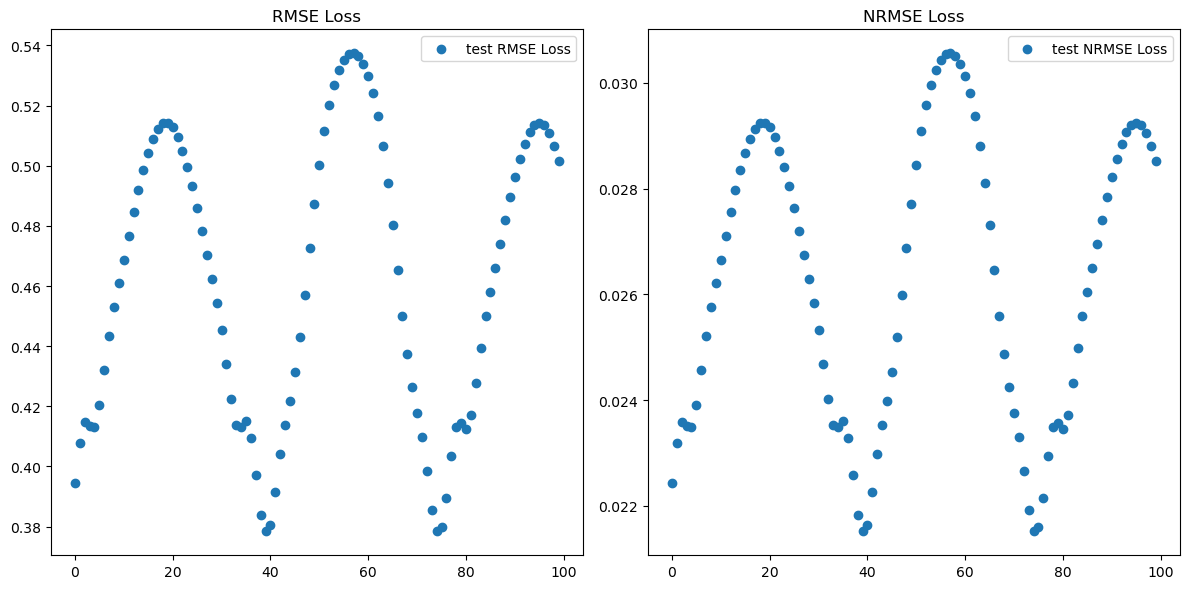

In [29]:
test_RMSE_Loss = np.array(test_RMSE_Loss)
test_NRMSE_Loss = np.array(test_NRMSE_Loss)

# 保存数组到 .npy 文件
np.save('test_rmse.npy', test_RMSE_Loss)
np.save('test_nrmse.npy', test_NRMSE_Loss)


fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

x = np.arange(0, 100)

axs[0].scatter(x, test_RMSE_Loss, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_NRMSE_Loss, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠
plt.savefig('GAE_test_loss.png')  # 你可以更改文件名或格式
plt.show()

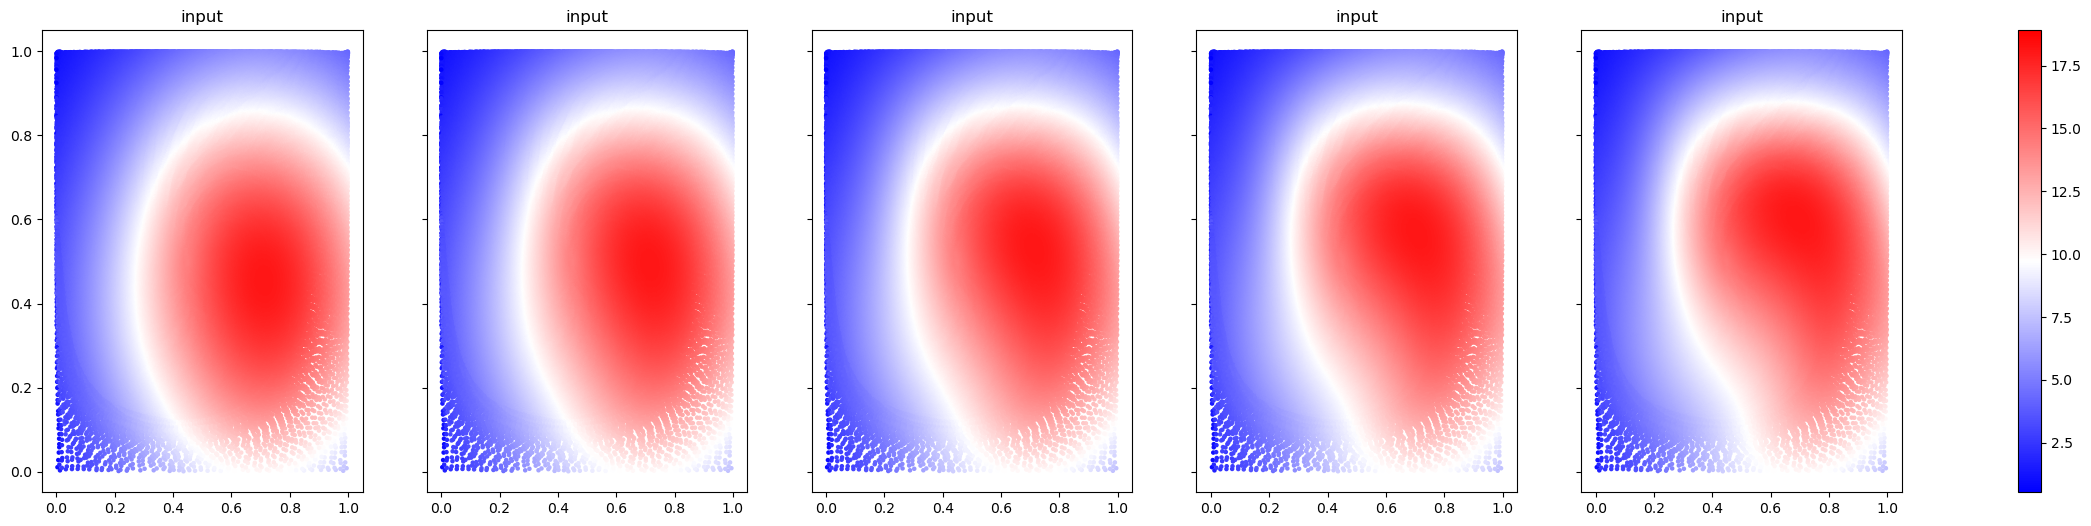

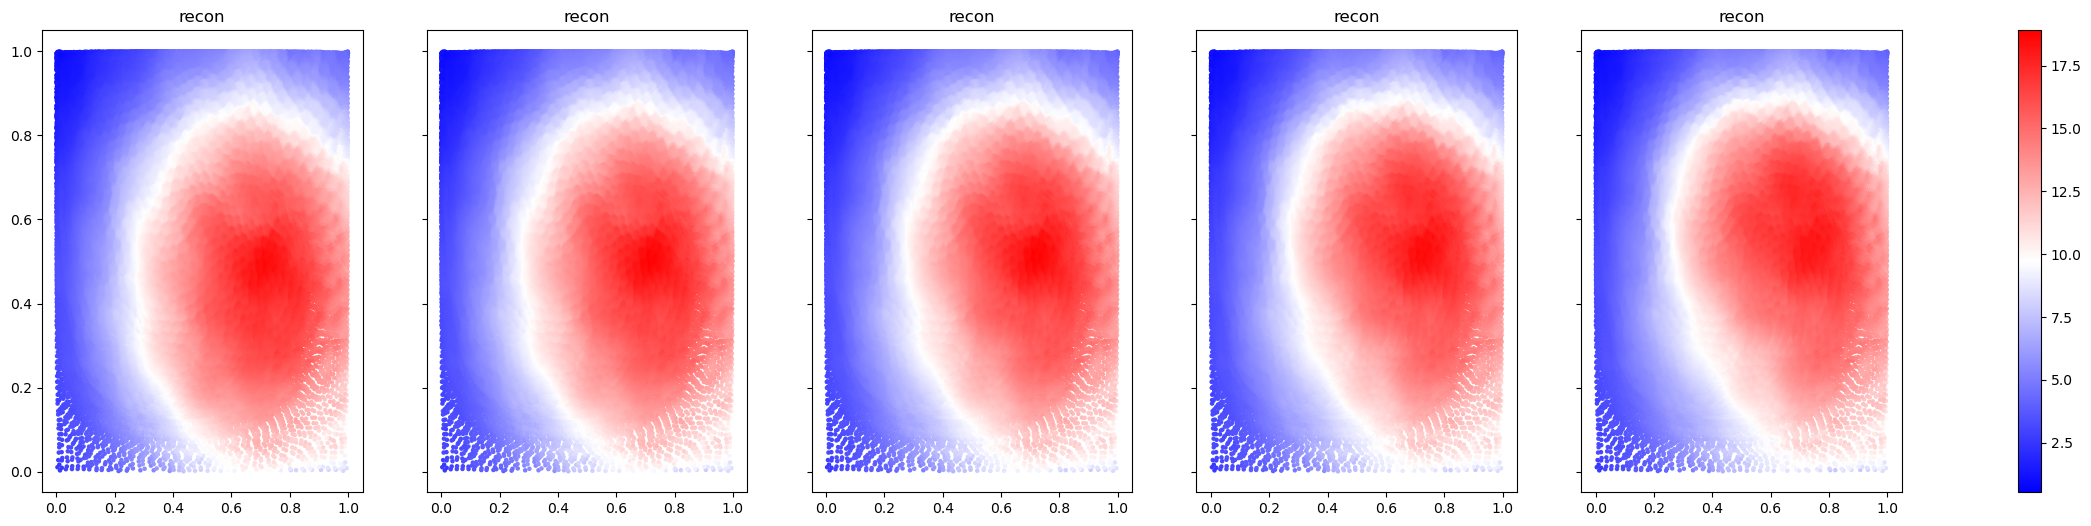

In [30]:
x = test_tensor_set[0:5]
recon_x = y[0:5]


x_np = x.cpu().detach().numpy()
recon_x_np = recon_x.cpu().detach().numpy()
pos_np = pos.cpu().detach().numpy()
draw_pic(x_np, recon_x_np, pos_np)